# ML Challenge
# DA24C005

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix

In [3]:
embedding1 = '/kaggle/input/challenge-dataset/embeddings_1.npy'
label1 = '/kaggle/input/challenge-dataset/icd_codes_1.txt'
embedding2 = '/kaggle/input/challenge-dataset/embeddings_2.npy'
label2 = '/kaggle/input/challenge-dataset/icd_codes_2.txt'
test_data = '/kaggle/input/challenge-dataset/test_data.npy'

In [4]:
labels = []
for f in [label1,label2]:
    with open(f, 'r') as file:
        labels += [line.strip().replace("'", "").split(';') for line in file]

embeddings1 = np.load(embedding1)
embeddings2 = np.load(embedding2)
embeddings = np.vstack([embeddings1, embeddings2])

### Multi hot encoding to transform text labels into binary representation as ML models can only process numerical input

In [5]:
mlb = MultiLabelBinarizer()
multihot_labels = mlb.fit_transform(labels)

### Visualising the most frequent label codes

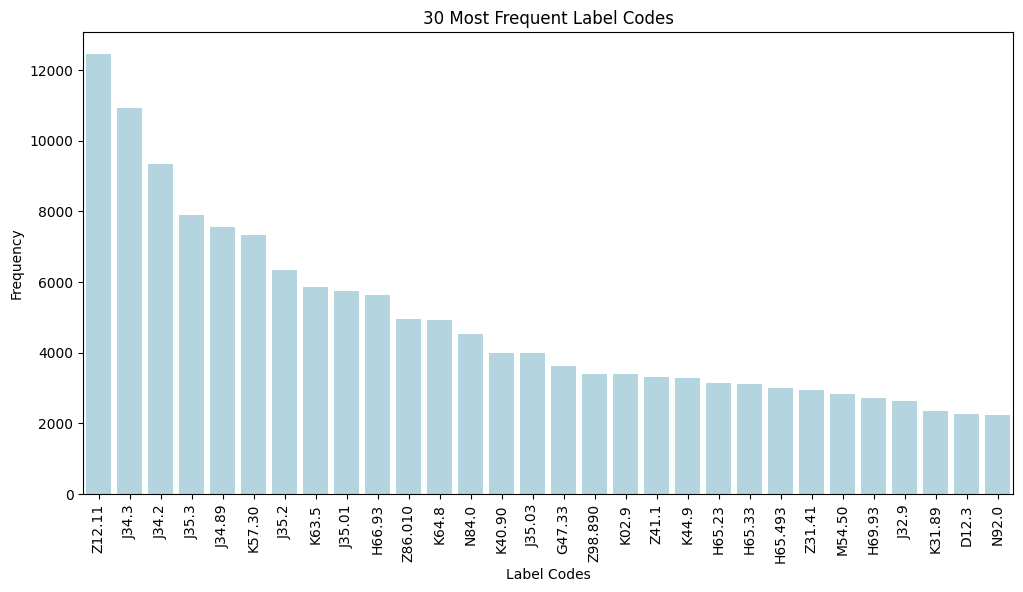

In [6]:
labels_ = [code for sublist in labels for code in sublist]
label_freq = pd.Series(labels_).value_counts()
plt.figure(figsize=(12, 6))
labels30 = label_freq[:30]
codes = labels30.index
freq = labels30.values
sns.barplot(x=codes, y=freq, color="lightblue")
plt.title('30 Most Frequent Label Codes')
plt.xlabel('Label Codes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


### Visualising the co-occurence of the 15 most frequent label codes 

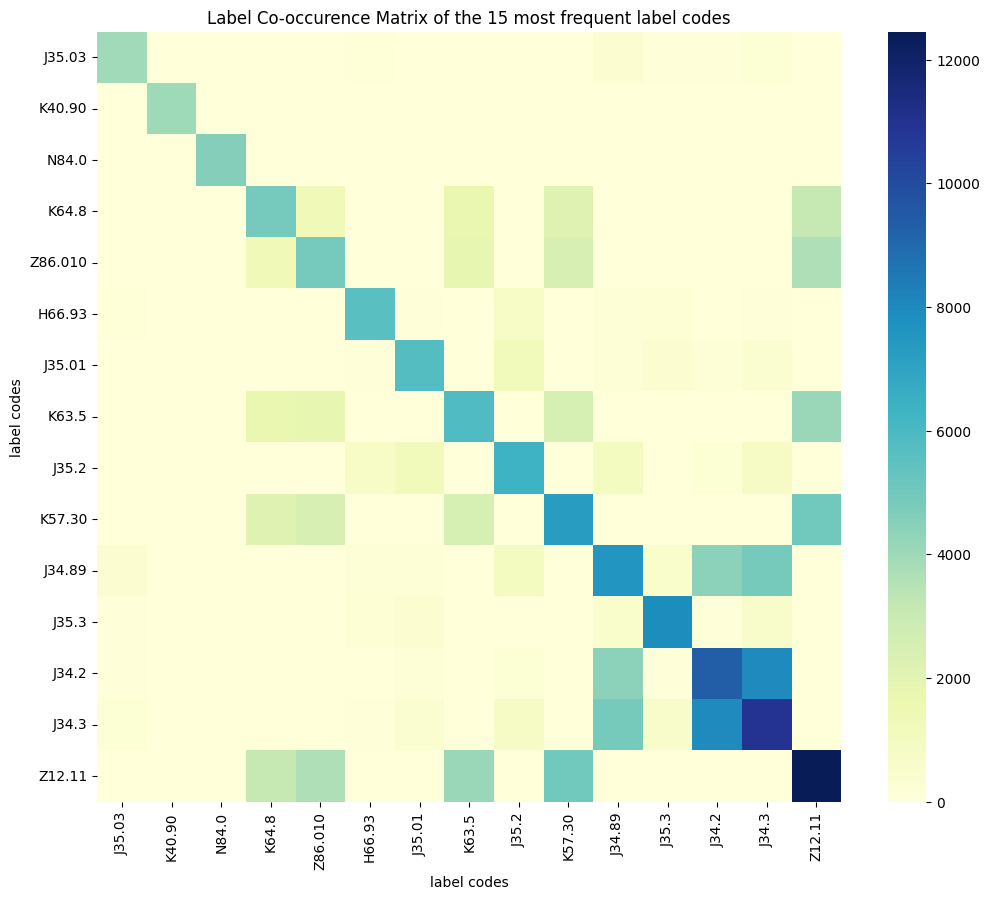

In [7]:
codes = mlb.classes_
labels_ = csr_matrix(multihot_labels)
freqs = labels_.sum(axis=0).A1
indices15 = np.argsort(freqs)[-15:]
labels15 = labels_[:, indices15]
co_occurrence = labels15.T.dot(labels15).toarray()
codes15 = [codes[i] for i in indices15]

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=False, cmap="YlGnBu", xticklabels=codes15, yticklabels=codes15)
plt.title("Label Co-occurence Matrix of the 15 most frequent label codes")
plt.xlabel("label codes")
plt.ylabel("label codes")
plt.show()

### Visualising the 15 most rarely occuring labels

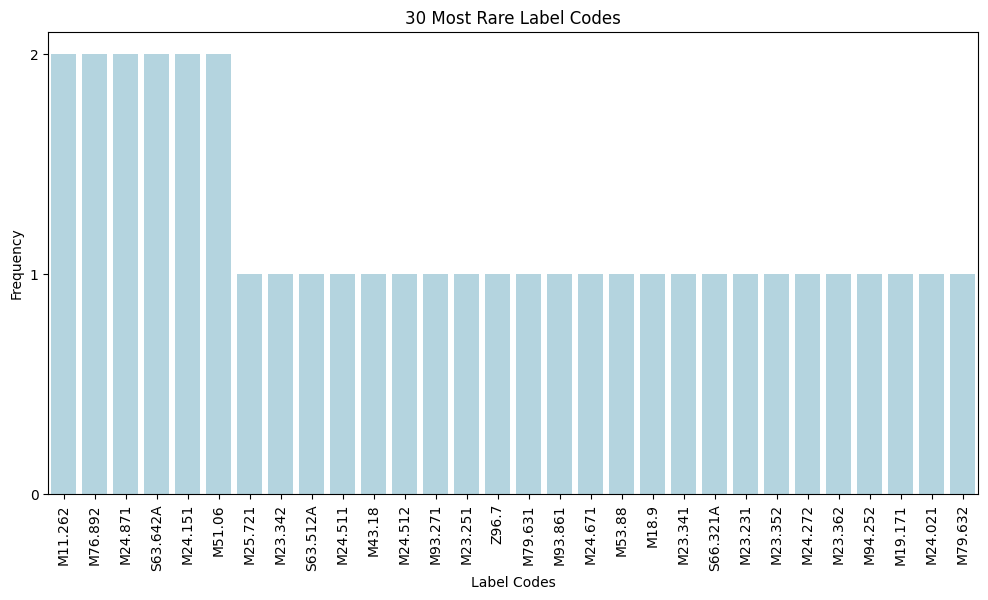

In [12]:
plt.figure(figsize=(12, 6))
labels30 = label_freq[-30:]
codes = labels30.index
freq = labels30.values
sns.barplot(x=codes, y=freq, color="lightblue")
plt.title('30 Most Rare Label Codes')
plt.xlabel('Label Codes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, np.max(freq) + 1, 1))
plt.show()


### Table to visualise the frequency distribution of the label codes

In [13]:
labels_ = [code for sublist in labels for code in sublist]
label_freq = pd.Series(labels_).value_counts()
freq = pd.cut(label_freq, bins=[0, 10, 100, 1000, 5000, 10000, float('inf')], 
              labels=['<10', '10-100', '100-1000', '1000-5000', '5000-10000', '>10000'], right=False)
label_freq_ = freq.value_counts().sort_index()

df = pd.DataFrame({
    'Frequency':label_freq_.index,
    'Label Codes': label_freq_.values
})
df


,Frequency,Label Codes
0,<10,187
1,10-100,574
2,100-1000,546
3,1000-5000,83
4,5000-10000,8
5,>10000,2


### Oversampling to address class imbalance

In [9]:
rare_threshold = 100
label_freq = multihot_labels.sum(axis=0)
rare_idx = np.where(label_freq < rare_threshold)[0]

os_embeds, os_labels = [], []
for i in range(len(embeddings)):
    os_embeds.append(embeddings[i])
    os_labels.append(multihot_labels[i])
    if any(multihot_labels[i][j] == 1 for j in rare_idx):
        os_embeds.append(embeddings[i])
        os_labels.append(multihot_labels[i])

os_embeddings = np.array(os_embeds)
os_labels = np.array(os_labels)

X_train, X_val, y_train, y_val = train_test_split(os_embeddings, os_labels, test_size=0.001, random_state=1)


### Custom function to calculate performance of the model using F2 score

In [10]:
def f2_score(y_actual, y_pred, threshold=0.5):
    y_actual = tf.cast(y_actual, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    
    true_pos = tf.reduce_sum(y_actual * y_pred)
    false_pos = tf.reduce_sum((1 - y_actual) * y_pred)
    false_neg = tf.reduce_sum(y_actual * (1 - y_pred))
    
    precision = true_pos / (true_pos + false_pos + tf.keras.backend.epsilon())
    recall = true_pos / (true_pos + false_neg + tf.keras.backend.epsilon())
    
    f2_score = (5 * precision * recall) / (4 * precision + recall + tf.keras.backend.epsilon())
    
    return f2_score


### Function to predict on test data

In [11]:
def predict(model, test_data, mlb):
    test_embeddings = np.load(test_data)
    preds = model.predict(test_embeddings)
    pred_labels = (preds > 0.5).astype(int)
    pred_codes = mlb.inverse_transform(pred_labels)
    str_pred = [";".join(codes) for codes in pred_codes]
    submission = pd.DataFrame({'id': np.arange(1, len(str_pred) + 1), 'labels': str_pred})
    return submission
    

### Using neural network model using different values of `dropout` and `negative_slope`

In [12]:
dropouts = [0.5, 0.6, 0.7, 0.8]
neg_slopes = [0.1, 0.2, 0.3]
results = []

for d in dropouts:
    for ns in neg_slopes:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1024,)),
            tf.keras.layers.Dense(2900),
            tf.keras.layers.LeakyReLU(negative_slope=ns),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(d),
            tf.keras.layers.Dense(2900),
            tf.keras.layers.LeakyReLU(negative_slope=ns),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(d),
            tf.keras.layers.Dense(1400, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=[f2_score])

        h = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65, batch_size=128, verbose=0)
        
        train_loss = h.history['loss'][-1]
        train_f2 = h.history['f2_score'][-1]
        val_loss = h.history['val_loss'][-1]
        val_f2 = h.history['val_f2_score'][-1]
        
        results.append({
            'dropout': d, 
            'negative slope': ns, 
            'train loss': train_loss, 
            'train f2': train_f2,
            'validation loss': val_loss, 
            'validation f2': val_f2
        })
        
        submission = predict(model, test_data, mlb)
        submission.to_csv(f'dropout_{d}_negslope_{ns}.csv', index=False)


I0000 00:00:1731534386.297263     139 service.cc:145] XLA service 0x78d804004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731534386.297315     139 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731534386.297319     139 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731534390.275391     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


### Visualising the performance of different neural network models on train and validation data

In [2]:
result_df = pd.DataFrame(results)
result_df

,dropout,negative slope,train loss,train f2,validation loss,validation f2
0,0.5,0.1,0.000626,0.914677,0.001376,0.868200
1,0.5,0.2,0.000705,0.903479,0.001323,0.859466
2,0.5,0.3,0.000798,0.890446,0.001384,0.856970
3,0.6,0.1,0.000841,0.884251,0.001351,0.878619
4,0.6,0.2,0.000907,0.874769,0.001306,0.869177
5,0.6,0.3,0.000984,0.864075,0.001332,0.859350
6,0.7,0.1,0.001122,0.845012,0.001443,0.853594
7,0.7,0.2,0.001160,0.840220,0.001413,0.857456
8,0.7,0.3,0.001209,0.833573,0.001377,0.845616
9,0.8,0.1,0.001493,0.794311,0.001646,0.843956


### Visualising a grid of dropout and negative slope values to help us identity optimal hyperparameter values for our model

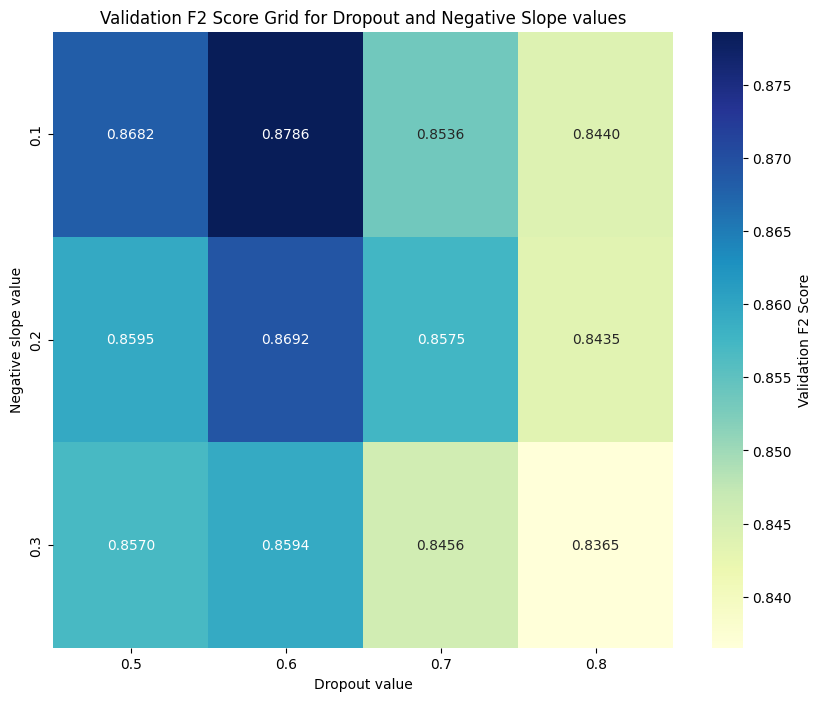

In [3]:
grid = result_df.pivot(index="negative slope", columns="dropout", values="validation f2")
plt.figure(figsize=(10, 8))
sns.heatmap(grid, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Validation F2 Score'})
plt.title("Validation F2 Score Grid for Dropout and Negative Slope values")
plt.xlabel("Dropout value")
plt.ylabel("Negative slope value")
plt.show()